In [2]:
# IMPORTS
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import lightkurve as lk
import tglc
import numpy as np

import os
from tglc.quick_lc import tglc_lc
import pickle
import glob

from scipy import ndimage

/opt/anaconda3/envs/AstroStats/lib/python3.12/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(
/opt/anaconda3/envs/AstroStats/lib/python3.12/site-packages/tglc/ffi.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
subset = pd.read_csv('hon_catalog_subset.csv')
subset

,Unnamed: 0,TIC,numax,e_numax,Tmag,Teff,e_Teff,Rstar,e_Rstar,Lstar,e_Lstar,Dist,e_Dist,RUWE,Flag,_RA,_DE,numax_bin
0,45239,140578874,37.3,2.5,8.0,4883,97,10.9,0.5,60.3,2.6,0.421,0.002,1.00,1,68.030649,-77.477397,1
1,46693,142305400,93.2,3.9,6.0,4787,95,6.6,0.3,20.5,0.6,0.105,0.000,0.88,1,41.387298,-42.838700,3
2,47925,144066888,59.1,3.3,8.0,5011,100,10.3,0.4,59.6,2.1,0.429,0.003,0.97,1,337.610637,-51.552294,2
3,49523,147565895,57.5,2.9,6.0,4750,95,7.5,0.3,25.6,0.8,0.113,0.000,1.05,1,163.680210,-42.018147,2
4,53314,155896371,91.5,3.8,8.0,4723,94,7.4,0.3,24.2,0.9,0.274,0.001,0.98,1,4.098704,-51.611425,3
5,59412,167169718,60.3,3.8,10.0,4788,95,7.5,0.4,26.7,1.5,0.686,0.005,1.01,1,97.008341,-66.627249,2
6,63033,176982730,31.4,2.2,10.0,4692,93,11.0,0.5,52.6,2.0,0.954,0.009,1.00,1,101.522427,-67.798416,1
7,80732,235906010,133.4,11.2,10.0,4796,95,5.3,0.2,13.3,0.4,0.489,0.003,1.07,1,290.352529,80.756842,4
8,96927,278702671,27.4,5.4,12.0,4846,96,10.1,0.5,50.8,3.6,2.420,0.076,1.00,1,334.579903,-41.530806,1
9,97637,279615774,124.6,5.6,8.0,4922,98,6.0,0.3,19.2,0.8,0.237,0.004,7.32,1,106.341828,-59.391192,4


In [11]:
# define lists for TIC id, numax, and uncertainties
tics = subset['TIC'].values
numaxes, e_numaxes = subset['numax'].values, subset['e_numax'].values

#### IMPORTANT ####

If you are running this for more than one star, you will need to update the index i below and re-run all the following cells to create light curves for the next star.

In [251]:
# index i in for list of selected stars, define tic numax and uncertainty for the star at index i
i = 0
tic = tics[i]
numax = numaxes[i]
e_numax = e_numaxes[i]

######
### Initialize functions and begin

In [252]:
# FUNCTION: this will run the tglc package

import os
import pickle
import numpy as np
import glob

def run_tglc(tic):
    """
    Load TGLC source and PSF data for a given TIC.
    Automatically detects correct sector/cam/ccd file using glob.
    """
    target = f'TIC {tic}'
    local_directory = f'tglc_outputs/{target}/'
    os.makedirs(local_directory, exist_ok=True)

    # Run tglc_lc to produce outputs (if not already present)
    tglc_lc(
        target=target,
        local_directory=local_directory,
        size=90,
        save_aper=True,
        limit_mag=16,
        get_all_lc=False,
        first_sector_only=True,
        last_sector_only=False,
        sector=None,
        prior=None,
        transient=None,
    )

    # --- Find matching files automatically ---
    pkl_files = glob.glob(os.path.join(local_directory, "source", f"source_*{target}*.pkl"))
    npy_files = glob.glob(os.path.join(local_directory, "epsf", f"epsf_*{target}*.npy"))

    if not pkl_files:
        raise FileNotFoundError(f"No .pkl file found for {target} in {local_directory}source/")
    if not npy_files:
        raise FileNotFoundError(f"No .npy file found for {target} in {local_directory}epsf/")

    # Assume only one match (since you said one sector per target)
    pkl_path = pkl_files[0]
    npy_path = npy_files[0]

    # --- Load source and epsf ---
    with open(pkl_path, "rb") as input_:
        source = pickle.load(input_)

    epsf = np.load(npy_path)

    # --- Identify target in catalog ---
    mask = source.tic["TIC"] == tic
    target_gaiadr3_source = source.tic[mask]["dr3_source_id"].value

    # --- Extract PSF and FFI cutouts ---
    epsf_images = epsf[:, :23**2].reshape(-1, 23, 23)
    ffi_images = source.flux[:, 34:57, 34:57]

    return ffi_images, epsf_images, target_gaiadr3_source


In [253]:
# FUNCTION: this will find the final aperture mask using clustering

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import HDBSCAN
from scipy.ndimage import label
from tqdm import tqdm

def find_aperture_mask(ffis, epsfs, min_fraction=0.5, min_cluster_size=4, min_samples=3):
        
    n_timesteps = epsfs.shape[0]
    apertures = []
    median_psf = np.nanmedian(epsfs, axis=0)
    median_ffi = np.nanmedian(ffis, axis=0)

    for epsf in tqdm(epsfs, desc="Finding apertures per timestep"):
        if np.all(np.isnan(epsf)):
            apertures.append(np.ones_like(epsf, dtype=bool))
            continue
        # Create coordinate grid
        y, x = np.indices(epsf.shape)
        X = np.column_stack([x.flatten(), y.flatten(), epsf.flatten()])

        # Scale for clustering
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Cluster
        clusterer = HDBSCAN(allow_single_cluster=True,
                            min_cluster_size=min_cluster_size,
                            min_samples=min_samples)
        fit = clusterer.fit(X_scaled)
        labels = fit.labels_

        # Find largest cluster (background)
        unique_labels, counts = np.unique(labels, return_counts=True)
        largest_cluster_label = unique_labels[np.argmax(counts)]

        # Inverse mask = aperture (exclude background)
        largest_cluster_mask = (labels == largest_cluster_label)
        t_aperture = ~(largest_cluster_mask.reshape(epsf.shape))

        # Keep largest connected region (4-connectivity)
        #labeled_array, num_features = label(t_aperture, connectivity=1)
        # Define 4-connectivity structure manually (no diagonals)
        structure = np.array([[0, 1, 0],
                              [1, 1, 1],
                              [0, 1, 0]])
        labeled_array, num_features = label(t_aperture, structure=structure)
        if num_features > 0:
            component_sizes = np.bincount(labeled_array.ravel())[1:]
            largest_component = np.argmax(component_sizes) + 1
            new_mask = (labeled_array == largest_component)
        else:
            new_mask = t_aperture

        apertures.append(new_mask)

    # Stack all timestep apertures and combine
    apertures_stack = np.array(apertures)
    aperture_fraction = np.mean(apertures_stack, axis=0)
    final_aperture = aperture_fraction >= min_fraction

    # --- Visualization ---
    fig, ax = plt.subplots(figsize=(6, 6))

    # Show PSF image as background
    im = ax.imshow(median_psf, cmap='viridis', alpha=0.9)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Overlay hollow red squares for aperture pixels
    for y, x in zip(*np.where(final_aperture)):
        rect = patches.Rectangle(
            (x - 0.5, y - 0.5),  # lower-left corner
            1, 1,                # width, height
            linewidth=1.5,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)

    ax.set_title("HDBSCAN Aperture Overlay ePSF", fontsize=14)
    ax.set_xlabel("X Pixel")
    ax.set_ylabel("Y Pixel")
    plt.show()

    fig, ax = plt.subplots(figsize=(6, 6))
    # Show FFI image as background
    im = ax.imshow(median_ffi, cmap='viridis', alpha=0.9)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Overlay hollow red squares for aperture pixels
    for y, x in zip(*np.where(final_aperture)):
        rect = patches.Rectangle(
            (x - 0.5, y - 0.5),  # lower-left corner
            1, 1,                # width, height
            linewidth=1.5,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)

    ax.set_title("HDBSCAN Aperture Overlay FFI", fontsize=14)
    ax.set_xlabel("X Pixel")
    ax.set_ylabel("Y Pixel")
    plt.show()

    return final_aperture, apertures

In [254]:
# FUNCTION: this will initialize a square 3x3 aperture for comparison

def square_aperture_like(mask, size=3):
    """Create a centered square aperture with the same centroid as mask."""
    ny, nx = mask.shape
    mask = np.zeros((ny, nx), dtype=bool)

    # Find central pixel
    cy, cx = ny // 2, nx // 2
    half = size // 2

    # Define box bounds (clipped to image edges)
    y_min = max(cy - half, 0)
    y_max = min(cy + half + 1, ny)
    x_min = max(cx - half, 0)
    x_max = min(cx + half + 1, nx)

    mask[y_min:y_max, x_min:x_max] = True
    return mask

In [255]:
# FUNCTION: this will correct the light curve following the RegressionCorrector tutorial from the lightkurve docs page

def correct_lc(time, flux, background, psf_images, aperture):
    import lightkurve as lk
    from lightkurve.correctors import DesignMatrix
    from lightkurve.correctors import RegressionCorrector
    
    # Make an aperture mask and an uncorrected light curve
    aper = aperture
    uncorrected_lc = lk.LightCurve(time=time,flux=flux)

    # Make a design matrix and pass it to a linear regression corrector
    dm = DesignMatrix(background, name='regressors').pca(10).append_constant()
    rc = RegressionCorrector(uncorrected_lc)
    corrected_ffi_lc = rc.correct(dm)

    # Optional: Remove the scattered light, allowing for the large offset from scattered light
    corrected_ffi_lc = uncorrected_lc - rc.model_lc + np.percentile(rc.model_lc.flux, 5)

    return corrected_ffi_lc

In [257]:
# produce TESS full-frame images and effective PSF images from tglc.
# This may take a minute to run since it uses online queries
# Currently this takes just the first sector of available TESS data, the run_tglc function 
# defined above can be modified to take a specific sector or all available sectors
ffi_images, psf_images, gaia_id = run_tglc(tic)

Target: TIC 459917383
  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0005-1-4      5      1   4
Only processing the first sector the target is observed in: Sector 5.
Target Gaia: Gaia DR2 3271925950318352128
INFO: Query finished. [astroquery.utils.tap.core]
Found 1910 Gaia DR3 objects.
Found 404 TIC objects.
INFO: Query finished. [astroquery.utils.tap.core]
Already in sector 5.


Fitting ePSF: 100%|██████████| 1196/1196 [00:18<00:00, 63.60it/s]
/opt/anaconda3/envs/AstroStats/lib/python3.12/site-packages/tglc/target_lightcurve.py:257: UserWarning: TESS FFI cut includes Nan values. Please shift the center of the cutout to remove Nan near edge. Target: TIC 459917383
  warnings.warn(
Fitting lc: 100%|██████████| 1/1 [00:00<00:00, 20.89it/s]


Finding apertures per timestep: 100%|██████████| 1196/1196 [00:03<00:00, 391.83it/s]


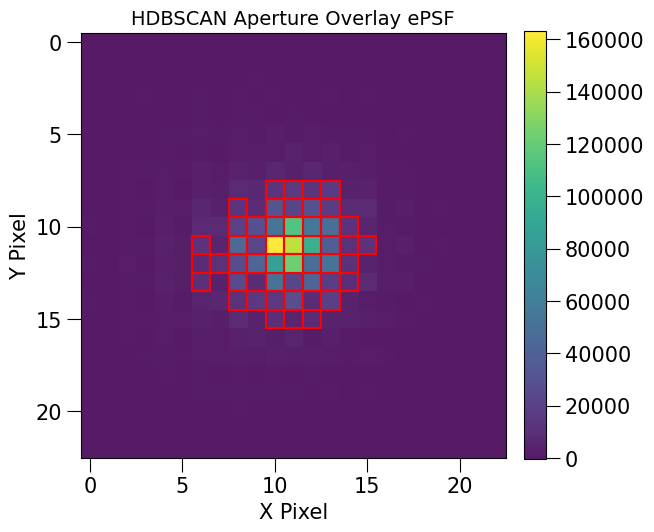

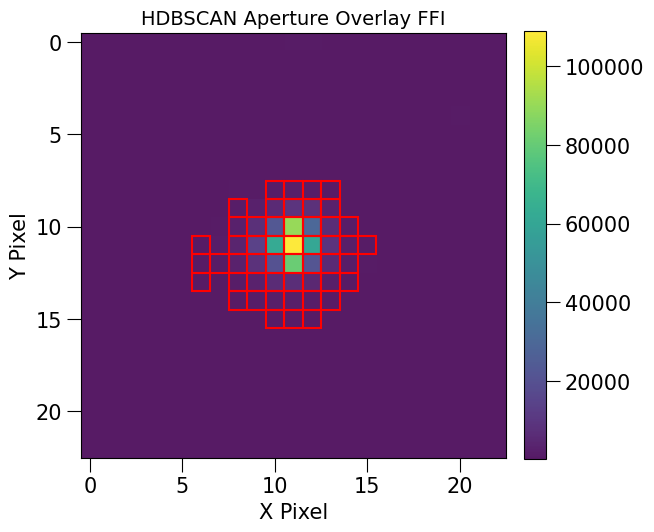

In [258]:
# define the final aperture 'aperture' and the apertures at each timestep 't_apers'
# you can modify some of the clustering parameters, if you'd like, but I have set the ones I used.
aperture, t_apers = find_aperture_mask(ffi_images, psf_images, min_fraction=0.75, min_cluster_size=4, min_samples=3)

In [259]:
# This will read in the light curve data that tglc produces
# this is used only to remove timesteps with poor quality flags

file = glob.glob(f'tglc_outputs/TIC {tic}/lc/*{gaia_id[0]}*.fits')
hdul_s007 = fits.open(file[0])
hdul_s007.info()
q_07 = [a and b for a, b in zip(list(hdul_s007[1].data['TESS_flags'] == 0),
                                list(hdul_s007[1].data['TGLC_flags'] == 0))]
time = hdul_s007[1].data['time'][q_07]

Filename: tglc_outputs/TIC 459917383/lc/hlsp_tglc_tess_ffi_gaiaid-3271925950318352128-s0005-cam1-ccd4_tess_v2_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (5, 5, 1196)   float32   
  1  LIGHTCURVE    1 BinTableHDU     59   1196R x 9C   [D, E, E, E, E, E, J, I, I]   
  2                1 ImageHDU         8   (5, 5, 3)   float64   


In [260]:
# generate raw flux for the cluster aperture
raw_flux_cls = np.sum(psf_images[:, aperture], axis=1)[q_07]
raw_bkg_cls = np.sum(psf_images[:, ~aperture], axis=1)[q_07]

# generate raw flux for the 3x3 aperture
mask_3x3 = square_aperture_like(aperture, size=3)
raw_flux_3x3 = np.sum(psf_images[:, mask_3x3], axis=1)[q_07]
raw_bkg_3x3 = np.sum(psf_images[:, ~aperture], axis=1)[q_07]

# the [q_07] mask removes poor quality timesteps

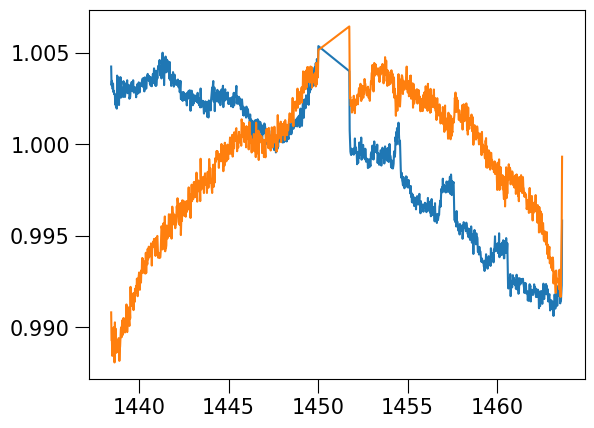

In [261]:
# plot light curves :)

plt.plot(time, raw_flux_cls/np.median(raw_flux_cls))
plt.plot(time, raw_flux_3x3/np.median(raw_flux_3x3))

plt.show()

In [262]:
# correct light curves using lightkurve's RegressionCorrector
corr_lc_cls = correct_lc(time, raw_flux_cls, raw_bkg_cls, psf_images, aperture)
corr_lc_3x3 = correct_lc(time, raw_flux_3x3, raw_bkg_3x3, psf_images, mask_3x3)

In [263]:
# create directory to save light curves
directory = f'pipeline_outputs/TIC{tic}/'
os.makedirs(directory, exist_ok=True)

# convert light curves to pandas and save as CSV
corr_lc_cls.to_pandas().to_csv(f'{directory}corrected_lc_adaptive1.csv')
corr_lc_3x3.to_pandas().to_csv(f'{directory}corrected_lc_3x3.csv')